# Utils

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [3]:
import pickle

def get_tree_dict(pickle_path):
    try: 
        with open(pickle_path, 'rb') as file:
            tree = pickle.load(file)
            return tree
    except:
        print("Can't open file!")

In [4]:
def get_root_id(tree_dict):
    for key, item in tree_dict.items():
        if item['pnode_id'] == -1:
            root_id = key
    return root_id

In [5]:
import treelib

def visualize_rst_tree(tree_dict, root_id, edu_list, new_relation=False, get_edu_text=False):
    rst_tree = treelib.Tree()
    relation_key = 'relation' if not new_relation else 'new_relation'
    node_list = [root_id]

    while node_list:
        id = node_list.pop()
        node = tree_dict[id]
        if (tree_dict.get(node['lnode_id']) is None) and (tree_dict.get(node['rnode_id']) is None):
            node_text = " EDU " + str(node['edu_span'])
            if get_edu_text:
                node_text += ": " + edu_list[node['edu_span'][0] - 1]
            rst_tree.create_node(node_text, id, parent=node['pnode_id'])
        else:
            node_text = node['node_form']

            if node['node_form'] == 'NN':
                node_text += "-" + tree_dict[node['rnode_id']][relation_key]
            elif node['node_form'] == 'NS':
                node_text += "-" + tree_dict[node['rnode_id']][relation_key]
            elif node['node_form'] == 'SN':
                node_text += "-" + tree_dict[node['lnode_id']][relation_key]
            else:
                raise ValueError("Unrecognized N-S form")
            
            if rst_tree.get_node(node['pnode_id']) is not None:
                rst_tree.create_node(node_text, id, parent=node['pnode_id'])
            else:
                rst_tree.create_node(node_text, id)
                print("\nNo parent at node: ", node_text, '\n')

        if tree_dict.get(node['rnode_id']) is not None:
            node_list.append(node['rnode_id'])
        if tree_dict.get(node['lnode_id']) is not None:
            node_list.append(node['lnode_id'])

    return rst_tree

In [6]:
def get_edus_from_file(edu_path):
    """Get EDUs from .edu file and return a list of EDUs
    """
    edus = []
    try: 
        with open(edu_path, 'r') as file:
            for line in file:
                if not line.strip():
                    continue
                edus.append(line.rstrip('\n'))
        return edus    
    except FileNotFoundError:
        print("Error: File not found!")


In [74]:
def extract_segments(edu_list, tree_dict, root_id): # use this when unpickling
    """Extract text segments from (1 or several EDUs) for relation labeller to read from (and make predictions)

    Args:
        edu_list: list containing EDUs (list)
        tree_dict: dict containing tree (dict)

    Return:
        Dict containing text of nucleus, satellite, and original relation from StageDP (dict)
    """

    segments = {'pnode_id': [], 'nucleus': [], 'satellite': [], 'original_relation': []} # if multi-nuclear, satellite represent second nucleus
    node_list = [root_id]
    while node_list:
        id = node_list.pop()
        node = tree_dict[id]

        if (tree_dict.get(node['lnode_id']) is None) and (tree_dict.get(node['rnode_id']) is None): # node is EDU
            continue
    
        left_edu_span = tree_dict[node['lnode_id']]['edu_span'] # tuple: (from, to)
        right_edu_span = tree_dict[node['rnode_id']]['edu_span'] # tuple: (from, to)
        
        # get corresponding text segments
        left_segment = ""
        for edu in range(left_edu_span[0], left_edu_span[1] + 1):
            left_segment += edu_list[edu - 1].strip() + ' '

        right_segment = ""
        for edu in range(right_edu_span[0], right_edu_span[1] + 1):
            right_segment += edu_list[edu - 1].strip() + ' '

        if node['node_form'] == 'NN':
            nucleus = left_segment
            satellite = right_segment
            relation = tree_dict[node['rnode_id']]['relation']
        elif node['node_form'] == 'NS':
            nucleus = left_segment
            satellite = right_segment
            relation = tree_dict[node['rnode_id']]['relation']
        elif node['node_form'] == 'SN':
            nucleus = right_segment
            satellite = left_segment
            relation = tree_dict[node['lnode_id']]['relation']

        segments['nucleus'].append(nucleus)
        segments['satellite'].append(satellite)
        segments['original_relation'].append(relation)
        segments['pnode_id'].append(id)  
        
        if tree_dict.get(node['lnode_id']) is not None:
            node_list.append(node['lnode_id'])
        if tree_dict.get(node['rnode_id']) is not None:
            node_list.append(node['rnode_id'])
    
    return segments

In [75]:
import copy
def add_new_relations_to_tree_dict(tree_dict, new_relations):
    """Extract text segments from (1 or several EDUs) for relation labeller to read from (and make predictions)

    Args:
        tree_dict: dict containing tree (dict)
        new_relations: df containing parent id and new relations (and other components no considered in this method)

    Return:
        New modified tree_dict according to new relations identified
    """
    tree_dict_c = copy.deepcopy(tree_dict)
    for _, r in new_relations.iterrows():
        p_id = r['pnode_id']
        rel = r['new_relation']
        if tree_dict_c[p_id]['node_form'] == 'NN':
            tree_dict_c[tree_dict_c[p_id]['rnode_id']]['new_relation'] = rel
            tree_dict_c[tree_dict_c[p_id]['lnode_id']]['new_relation'] = rel
        elif tree_dict_c[p_id]['node_form'] == 'NS':
            tree_dict_c[tree_dict_c[p_id]['rnode_id']]['new_relation'] = rel
        elif tree_dict_c[p_id]['node_form'] == 'SN':
            tree_dict_c[tree_dict_c[p_id]['lnode_id']]['new_relation'] = rel
        
    return tree_dict_c 

In [9]:
def write_to_text_file(text_path, text):
    """Write string in text to text_path. The text is to be analyzed using RST and generated questions from. 

    Args:
        text_path (str): path of file to write to
        text (str): text to write to (informational text to extract questions from)
    """

    try:
        with open(text_path, 'w') as f:
            f.write(text)
    except:
        print("Can't open text file!\n")

In [12]:
# run this cell to start processing text

original_text = """A transformer model is a type of deep learning model that was introduced in 2017. These models have quickly become fundamental in natural language processing (NLP), and have been applied to a wide range of tasks in machine learning and artificial intelligence.

The model was first described in a 2017 paper called "Attention is All You Need" by Ashish Vaswani, a team at Google Brain, and a group from the University of Toronto. The release of this paper is considered a watershed moment in the field, given how widespread transformers are now used in applications such as training LLMs.

These models can translate text and speech in near-real-time. For example, there are apps that now allow tourists to communicate with locals on the street in their primary language. They help researchers better understand DNA and speed up drug design. They can hep detect anomalies and prevent fraud in finance and security. Vision transformers are similarly used for computer vision tasks.

OpenAI’s popular ChatGPT text generation tool makes use of transformer architectures for prediction, summarization, question answering and more, because they allow the model to focus on the most relevant segments of input text. The “GPT” seen in the tool’s various versions (e.g. GPT-2, GPT-3) stands for “generative pre-trained transformer.” Text-based generative AI tools such as ChatGPT benefit from transformer models because they can more readily predict the next word in a sequence of text, based on a large, complex data sets.

The BERT model, or Bidirectional Encoder Representations from Transformers, is based on the transformer architecture. As of 2019, BERT was used for nearly all English-language Google search results, and has been rolled out to over 70 other languages.

The key innovation of the transformer model is not having to rely on recurrent neural networks (RNNs) or convolutional neural networks (CNNs), neural network approaches which have significant drawbacks. Transformers process input sequences in parallel, making it highly efficient for training and inference — because you can’t just speed things up by adding more GPUs. Transformer models need less training time than previous recurrent neural network architectures such as long short-term memory (LSTM).

RNNs and LSTM date back to the 1920s and 1990s, respectively. These techniques compute each component of an input in sequence (e.g. word by word), so computation can take a long time. What’s more, both approaches run into limitations in retaining context when the “distance” between pieces of information in an input is long.

There are two primary innovations that transformer models bring to the table. Consider these two innovations within the context of predicting text.

Positional encoding: Instead of looking at each word in the order that it appears in a sentence, a unique number is assigned to each word. This provides information about the position of each token (parts of the input such as words or subword pieces in NLP) in the sequence, allowing the model to consider the sequence's sequential information.

Self-attention: Attention is a mechanism that calculates weights for every word in a sentence as they relate to every other word in the sentence, so the model can predict words which are likely to be used in sequence. This understanding is learned over time as a model is trained on lots of data. The self-attention mechanism allows each word to attend to every other word in the sequence in parallel, weighing their importance for the current token. In this way, it can be said that machine learning models can “learn” the rules of grammar, based on statistical probabilities of how words are typically used in language.

Transformer models work by processing input data, which can be sequences of tokens or other structured data, through a series of layers that contain self-attention mechanisms and feedforward neural networks. The core idea behind how transformer models work can be broken down into several key steps.

Let’s imagine that you need to convert an English sentence into French. These are the steps you’d need to take to accomplish this task with a transformer model.

Input embeddings: The input sentence is first transformed into numerical representations called embeddings. These capture the semantic meaning of the tokens in the input sequence. For sequences of words, these embeddings can be learned during training or obtained from pre-trained word embeddings.

Positional encoding: Positional encoding is typically introduced as a set of additional values or vectors that are added to the token embeddings before feeding them into the transformer model. These positional encodings have specific patterns that encode the position information.

Multi-head attention: Self-attention operates in multiple "attention heads" to capture different types of relationships between tokens. Softmax functions, a type of activation function, are used to calculate attention weights in the self-attention mechanism.

Layer normalization and residual connections: The model uses layer normalization and residual connections to stabilize and speed up training.

Feedforward neural networks: The output of the self-attention layer is passed through feedforward layers. These networks apply non-linear transformations to the token representations, allowing the model to capture complex patterns and relationships in the data.

Stacked layers: Transformers typically consist of multiple layers stacked on top of each other. Each layer processes the output of the previous layer, gradually refining the representations. Stacking multiple layers enables the model to capture hierarchical and abstract features in the data.

Output layer: In sequence-to-sequence tasks like neural machine translation, a separate decoder module can be added on top of the encoder to generate the output sequence.

Training: Transformer models are trained using supervised learning, where they learn to minimize a loss function that quantifies the difference between the model's predictions and the ground truth for the given task. Training typically involves optimization techniques like Adam or stochastic gradient descent (SGD).

Inference: After training, the model can be used for inference on new data. During inference, the input sequence is passed through the pre-trained model, and the model generates predictions or representations for the given task.

""" 
original_text = original_text.replace(u"\u2018", "'").replace(u"\u2019", "'").replace(u"\u2013", "-").replace(u"\u2014", "-").replace(u"\u201C", "-").replace(u"\u201D", "-") 
text_path = "../parsers-from-github/StageDP_2/data/my_sample/sample"

write_to_text_file(text_path, original_text)

In [78]:
len(original_text.split())

984

In [76]:
# run this cell to process new data, adjust paths if necessary

pickle_path = "../parsers-from-github/StageDP_2/data/my_sample/sample.pickle"
edu_path = "../parsers-from-github/StageDP_2/data/my_sample/sample.edus"

tree_dict = get_tree_dict(pickle_path)
root_id = get_root_id(tree_dict)
edus = get_edus_from_file(edu_path)
rst_tree = visualize_rst_tree(tree_dict, root_id, edus, get_edu_text=True)

# print(rst_tree.show(stdout=False, sorting=False)) # uncomment to visualize RST tree
# print(edus)

segments = extract_segments(edus, tree_dict, root_id)
df = pd.DataFrame(segments)
df.shape


No parent at node:  NS-Elaboration 



(130, 4)

In [77]:
# assembly the whole piece of text from EDUs, to ensure allignment

original_text = ""
for edu in edus:
    original_text += edu + ' '

In [15]:
# map "Comparison" to "Join" since GUM does not contain "Comparison"
for row in df[df['original_relation'] == 'Comparison'].iterrows():
    df.at[row[0], 'original_relation'] = "Joint"

# Relation Labeller

In [79]:
# run this cell only once
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "output_train_all_with_additional_reverse_dataset1/checkpoint-45000"
if 'tokenizer' not in locals(): # prevent accidental re-run of cell
    tokenizer = AutoTokenizer.from_pretrained(model_path)

if 'model' not in locals(): # prevent accidental re-run of cell
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(torch.device('cuda'))

Preprocess Data

In [80]:
# get labels
from sklearn.preprocessing import LabelEncoder
label_text = ['Attribution', 'Background', 'Cause', 'Condition', 'Contrast',
       'Elaboration', 'Enablement', 'Evaluation', 'Explanation', 'Joint',
       'Manner-Means', 'Same-Unit', 'Summary', 'Temporal',
       'Textual-Organization', 'Topic-Change', 'Topic-Comment']

label_shorthand = ['Attr', 'Bckg', 'Cause', 'Cond', 'Contst',
       'Elab', 'Enab', 'Eval', 'Expl', 'Joint',
       'Man-Mean', 'Same-Un', 'Sum', 'Temp',
       'Text-Org', 'Top-Chang', 'Top-Com']

le = LabelEncoder()
le.fit(label_text)
labels = le.transform(df.original_relation)

In [81]:
# adding <sep> token between nucleus and satellite
separation_token = "[SEP]"
input_sentences = df.apply(lambda x: ''.join([x['nucleus'], separation_token, x['satellite']]), axis=1)

In [82]:
# merge input sentence and labels onto one list (to form dataset object later)
data = []
for text in input_sentences:
    datapoint = {'text': text}
    data.append(datapoint)
data = np.array(data)

In [83]:
# tokenize
import datasets

def tokenize_function(dataset):
    return tokenizer(dataset["text"], padding=True, truncation=True, return_tensors='pt')

# Inference

Batch Inference

In [84]:
device = 'cuda'
model.to(device)
model.eval()

batch_size = 32
dataset = datasets.Dataset.from_list(list(data))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

pred_labels = []

with torch.no_grad():
    for batch in dataloader:
        tokens = tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt').to(device)
        output = model(**tokens)
        logits = torch.Tensor.cpu(output.logits)
        pred_labels.extend(np.argmax(logits, axis=-1).tolist())

In [85]:
preds = le.inverse_transform(pred_labels)
df['new_relation'] = preds

In [86]:
# calculate porportion of changed labels

diff = df.apply(lambda x: x['original_relation'] != x['new_relation'], axis=1)
print(diff.sum(), "changed relations out of", df.shape[0], '(' + str(round(float(diff.sum()/df.shape[0]), 2)) + ')')
df[diff]

61 changed relations out of 130 (0.47)


pnode_id  \
0    140334317846256   
1    140334317846144   
2    140334317846312   
3    140334317846368   
4    140334317845920   
..               ...   
122  140334317791104   
123  140334317789872   
124  140334317790488   
126  140334317789536   
128  140334317790824   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 nucleus  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    A transformer model is a type of deep learning model that was introduced in 2017. These models have quickly become fundamental in natural language processing (NLP), and have been applied to a wide range of tasks in machine learning and artificial intelligence. The model was first described in a 2017 paper called "Attention is All You Need" by Ashish Vaswani, a team at Google Brain, and a group from the University of Toronto. The release of this paper is considered a watershed moment in the field, given how widespread transformers are now used in applications such as training LLMs. These models can translate text and speech in near-real-time. For example, there are apps that now allow tourists to communicate with locals on the street in their primary language. They help researchers better understand DNA and speed up drug design. They can hep detect anomalies and prevent fraud in finance and security. Vision transformers are similarly used for computer vision tasks.    
1    OpenAI's popular ChatGPT text generation tool makes use of transformer architectures for prediction, summarization, question answering and more, because they allow the model to focus on the most relevant segments of input text. The - GPT- seen in the tool's various versions (e.g. GPT-2, GPT-3) stands for - generative pre-trained transformer.- Text-based generative AI tools such as ChatGPT benefit from transformer models because they can more readily predict the next word in a sequence of text, based on a large, complex data sets. The BERT model, or Bidirectional Encoder Representations from Transformers, is based on the transformer architecture. As of 2019, BERT was used for nearly all English-language Google search results, and has been ro

In [87]:
# fix old tree with new relations

new_tree_dict = add_new_relations_to_tree_dict(tree_dict, df)
new_rst_tree = visualize_rst_tree(new_tree_dict, get_root_id(new_tree_dict), edus, new_relation=True, get_edu_text=True)

print(new_rst_tree.show(stdout=False, sorting=False)) # for visualizing rst_tree


No parent at node:  NS-Background 

NS-Background
├── NS-Elaboration
│   ├── NS-Background
│   │   ├── NS-Elaboration
│   │   │   ├──  EDU (1, 1): A transformer model is a type of deep learning model
│   │   │   └──  EDU (2, 2): that was introduced in 2017.
│   │   └── NN-Joint
│   │       ├── NS-Summary
│   │       │   ├──  EDU (3, 3): These models have quickly become fundamental in natural language processing
│   │       │   └──  EDU (4, 4): (NLP),
│   │       └──  EDU (5, 5): and have been applied to a wide range of tasks in machine learning and artificial intelligence.
│   └── NS-Elaboration
│       ├── NS-Evaluation
│       │   ├── NS-Elaboration
│       │   │   ├──  EDU (6, 6): The model was first described in a 2017 paper
│       │   │   └──  EDU (7, 7): called "Attention is All You Need" by Ashish Vaswani, a team at Google Brain, and a group from the University of Toronto.
│       │   └── NS-Explanation
│       │       ├──  EDU (8, 8): The release of this paper is considered a

<BarContainer object of 16 artists>

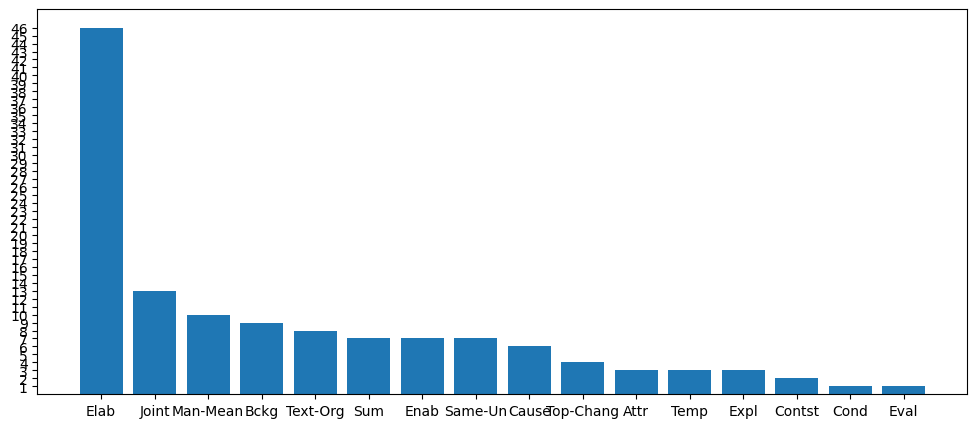

In [88]:
label_cnt = pd.Series(pred_labels).value_counts()
indices = pd.Series(label_shorthand).reindex(label_cnt.index, fill_value=0)

plt.figure(figsize=(12, 5))
plt.yticks(np.arange(1, max(label_cnt) + 1))
plt.bar(indices, label_cnt)

In [89]:
# find occurences of a specific relation

df[df["original_relation"] == "Cause"]

,pnode_id,nucleus,satellite,original_relation,new_relation
35,140334317843176,"Each layer processes the output of the previous layer,",gradually refining the representations.,Cause,Manner-Means
70,140334317792000,This understanding is learned over time,as a model is trained on lots of data.,Cause,Background


In [90]:
# find occurences of a specific relation

df[df["new_relation"] == "Contrast"]

,pnode_id,nucleus,satellite,original_relation,new_relation
2,140334317846312,"What's more, both approaches run into limitations in retaining context when the -distance- between pieces of information in an input is long.","There are two primary innovations that transformer models bring to the table. Consider these two innovations within the context of predicting text. Positional encoding: Instead of looking at each word in the order that it appears in a sentence, a unique number is assigned to each word. This provides information about the position of each token (parts of the input such as words or subword pieces in NLP) in the sequence, allowing the model to consider the sequence's sequential information. Self-attention: Attention is a mechanism that calculates weights for every word in a sentence as they relate to every other word in the sentence, so the model can predict words which are likely to be used in sequence. This understanding is learned over time as a model is trained on lots of data. The self-attention mechanism allows each word to attend to every other word in the sequence in parallel, weighing their importance for the current token. In this way, it can be said that machine learning models can -learn- the rules of grammar, based on statistical probabilities of how words are typically used in language. Transformer models work by processing input data, which can be sequences of tokens or other structured data, through a series of layers that contain self-attention mechanisms and feedforward neural networks. The core idea behind how transformer models work can be broken down into several key steps. Let's imagine that you need to convert an English sentence into French. These are the steps you'd need to take to accomplish this task with a transformer model. Input embeddings: The input sentence is first transformed into numerical representations called embeddings. These capture the semantic meaning of the tokens in the input sequence. For sequences of words, these embeddings can be learned during training or obtained from pre-trained word embeddings. Positional encoding: Positional encoding is typically introduced as a set of additional values or vectors that are added to the token embeddings before feeding them into the transformer model. These positional encodings have specific patterns that encode the position information. Multi-head attention: Self-attention operates in multiple ""attention heads"" to capture different types of relationships between tokens. Softmax functions, a type of activation function, are used to calculate attention weights in the self-attention mechanism. Layer normalization and residual connections: The model uses layer normalization and residual connections to stabilize and speed up training. Feedforward neural networks: The output of the self-attention layer is passed through feedforward layers. These networks apply non-linear transformations to the token representations, allowing the model to capture complex patterns and relationships in the data. Stacked layers: Transformers typically consist of multiple layers stacked on top of each other. Each layer processes the output of the previous layer, gradually refining the representations. Stacking multiple layers enables the model to capture hierarchical and abstract features in the data. Output layer: In sequence-to-sequence tasks like neural machine translation, a separate decoder module can be added on top of the encoder to generate the output sequence. Training: Transformer models are trained using supervised learning, where they learn to minimize a loss function that quantifies the difference between the model's predictions and the ground truth for the given task. Training typically involves optimization techniques like Adam or stochastic gradient descent (SGD). Inference: After training, the model can be used for inference on new data. During inference, the input sequence is passed through the pre-trained model, and the model generates

Helper Block

In [690]:
import spacy
from spacy import displacy
if 'nlp' not in locals(): # prevent accidental re-run of cell
    nlp = spacy.load('en_core_web_trf')

sent = "the model is trained using supervised learning."
doc = nlp(sent)
displacy.render(doc, style="dep")

In [672]:
for token in doc:
    print(token.children., '-', token.text, '-', token.ent_type_ , '-', token.dep_)

TypeError: 'generator' object is not subscriptable

In [641]:
for chunk in doc.noun_chunks:
    print(chunk.root, '-', chunk)

I - I
Tom - Tom
midnight - midnight


In [619]:
spacy.explain('NP')

'noun phrase'

End Helper Block

Individual Inference

In [95]:
device = 'cuda'
model.to(device)
model.eval()

sep = tokenizer.sep_token
text_n = "She used the tool in the garden, "
text_s = "in order to win."
text = text_n + sep + text_s

with torch.no_grad():
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
    output = model(**tokens)
    logits = torch.Tensor.cpu(output.logits)
    single_pred = int(np.argmax(logits, axis=-1))
    
le.inverse_transform([single_pred])[0]

'Enablement'

# Question Generation

Utils

In [96]:
RELATIVE_PRONOUNS = ['who', 'that', 'whose', 'which']

In [97]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_trf')
nlp_small = spacy.load("en_core_web_sm")

In [98]:
def get_subj(clause, accept_pron=True, accept_expl=False):
    """Return subject of clause, None of none found

    Args:
        clause (str): 
        accept_expl (bool, optional): If take expletive as subject. Defaults to False.
        accept_expl (bool, optional): If take pronoun as subject. Defaults to True.

    Returns:
        str: The subject
    """
    doc = nlp(clause)

    for token in doc:
        if 'nsubj' in token.dep_:
            if token.pos_ == "PRON" and not accept_pron:
                continue
            for chunk in doc.noun_chunks:
                if chunk.start <= token.i and token.i < chunk.end:
                    return chunk.text
        if accept_expl:
            if 'expl' in token.dep_:
                return token.text
    return None

In [691]:
# WORKING: make a more fool proof method of checking relative clause: inputing both source sents and text, and use pos tags to determine, refer to : is_dependent_clause()
def check_relative_clause(text):
    """Return if the text (has to contain only one clause) is a relative clause, 
    relative clauses can start with "which", "Ving, "Ved" (not including adverbial clause)

    Args:
        text
    Return
        boolean
    """
    doc = nlp(text)

    for token in doc:
        if (token.dep_ == "nsubj"):
            if (token.text.lower() in RELATIVE_PRONOUNS):
                return 1 # relative clause starting with relative pronouns
            return 0

    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if (token.pos_ == "VERB") and (token.tag_ in ['VBG', 'VBN']):
                # WORKING: Change way to check tense, use tag_ instead of morph
                if len(token.morph.get('Tense')) == 0:
                    return 0 # not relative clause
                if (token.text.endswith('ing')) or (token.tag_ ==  'VBN'):
                    return 2 # shortened relative clause (ending with Ving or Ved)
            else: 
                return 0

In [676]:
check_relative_clause("where they learn to minimize a loss function that quantifies the difference between the model's predictions and the ground truth for the given task.")

0

In [452]:
def find_boundary(sent_doc, text_doc):
    """Find boundary indices of text_doc in sent_doc (given that text_doc is in sent_doc)

    Args:
        sent_doc (nlp Doc): 
        text_doc (nlp Doc): 
    """
    start_ind = 0
    while start_ind < len(sent_doc):
        if text_doc.text not in sent_doc[start_ind:].text:
            break
        start_ind += 1
    start_ind -= 1

    end_ind = len(sent_doc)
    while end_ind > 0:
        if (text_doc.text not in sent_doc[:end_ind].text) or (end_ind <= start_ind):
            break
        end_ind -= 1
    end_ind += 1

    return start_ind, end_ind

def is_dependent_clause(src_sent, text):
    # WORKING: may use this way to check relative clause as well
    sent_doc = nlp(src_sent)
    text_doc = nlp(text)   

    start_ind, end_ind = find_boundary(sent_doc, text_doc)
    if start_ind < 0 or end_ind > len(sent_doc):
        print("\nText not found in source sentence!\n")
        return None

    for token in sent_doc[start_ind:end_ind]:
        if token.dep_ in ['acl', 'ccomp', 'advcl', 'xcomp']:
            if token.head.i in range(start_ind, end_ind):
                return False
            return True
    return False     

In [101]:
5 in range(6, 6)

False

In [688]:
unshorten_relative_clause("Training: Transformer models are trained using supervised learning", "using supervised learning")

learning


('Training: Transformer models are trained using which is supervised learning',
 'using which is supervised learning')

In [666]:
import inflect
p = inflect.engine()

def unshorten_relative_clause(original_sent, clause):
    """Unshorten relative clause (make sure it's a relative clause before calling this method) ending with Ving or Ved, convert them to which/who + V

    Args:
        clause (str): relative clause containing Ving or Ved
        original_sent (str): original sentence containing that clause
    Return:
        tuple(str, str): modified clause and source sentence
    """

    clause_doc = nlp(clause)
    text_doc = nlp(original_sent)
    vb = ""

    for token in clause_doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if (token.pos_ == "VERB") and (token.tag_ in ['VBG', 'VBN']): # finds Ving or Ved
                vb = token

    for v_token in text_doc:
        # find verb in original sentence
        if v_token.text == vb.text.strip():
            c_i = vb.i
            t_i = v_token.i
            is_verb = True
            while c_i < len(clause_doc) and t_i < len(text_doc):
                if clause_doc[c_i].text.strip() != text_doc[t_i].text.strip():
                    is_verb = False
                    break
                c_i += 1
                t_i += 1
            if is_verb:
                break
    
    pointed_noun = v_token.head
    pointed_noun_chunk = None
    for chunk in text_doc.noun_chunks:
        if chunk.start <= pointed_noun.i and pointed_noun.i < chunk.end:
            pointed_noun_chunk = chunk
    
    if pointed_noun_chunk:
        pointed_root_noun = pointed_noun_chunk.root
    else:
        pointed_root_noun = pointed_noun
    
    rel_pro = "which" 
    # not a fool-proof way to determine if noun is person
    if pointed_root_noun.ent_type_:
        if pointed_root_noun.ent_type_ == "PERSON":
            rel_pro = "who"

    # check plurality of noun/pronoun and conjugate accordingly
    # only applicable for Present Tense, not for past or others
    if pointed_root_noun.pos_.startswith("NOUN"): # noun
        plurality = pointed_root_noun.tag_ == "NNS"
    elif "PRON" in pointed_root_noun.pos_:  # pronoun
        plurality = (pointed_root_noun.lemma_ == "we") or (pointed_root_noun.lemma_ == "you") or (pointed_root_noun.lemma_ == "they") or ((pointed_root_noun.lemma_ == "I"))
    else: # WORKING: for other cases where relative pronoun does not point to a noun, but a verb or a clause
        plurality = False # temporary solution

    if not plurality:
        if vb.tag_ == 'VBG':
            conj_vb = p.plural_noun(vb.lemma_) # get singular conjugation (plural_noun() method works with verbs too)
        else:
            if pointed_root_noun.text.strip() == "I":
                aux = 'am'
            else:
                aux = 'is'
            conj_vb = aux + ' ' + vb.text
    else:
        if vb.tag_ == 'VGB':
            conj_vb = p.plural_verb(vb.lemma_) # get plural conjugation
        else:
            if pointed_root_noun.text.strip() == "I":
                aux = 'am'
            else:
                aux = 'are'
            conj_vb = aux + ' ' + vb.text

    fixed_clause = clause.replace(vb.text, rel_pro + ' ' +  conj_vb, 1)# replace only the first occurence of the verb
    fixed_sent = original_sent.replace(clause.strip(), fixed_clause.strip(), 1)
    return  (fixed_sent, fixed_clause)

In [667]:
unshorten_relative_clause("I saw Tom walking at midnight", "walking at midnight")

saw


('I saw Tom which walks at midnight', 'which walks at midnight')

In [593]:
# WORKING: Need to handle all types of shortened relative clauses, for now, only Ving and Ved is covered.

In [526]:
def is_one_clause(text, count_relative_clause=True):
    """Check if input text is one clause or multiple.
        NOTE: If not multiple clause, the method returns true, so does not account for the case of not a full clause, just check whether multiple clauses or not, cause a EDU is usually at least a clause semantically. 

    Args:
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    doc = nlp(text)

    # check how many subjects
    has_subj = False
    for token in doc:
        if "nsubj" in token.dep_:
            if not count_relative_clause:
                if token.text.lower() in ['who', 'whom', 'whose', 'which', 'that']:
                    continue
                if token.head.dep_ in ['relcl', 'acl', 'ccomp']:
                    continue
            if has_subj:
                return False
            else:
                has_subj = True
    return True # not return has_subj, so that even no subject will be 1 clause

In [105]:
def has_aux(sentence):
    """Check if sentence has auxiliary verb.
    Input one sentence only.
    """
    doc = nlp(sentence)
    for token in doc:
        if "AUX" in token.pos_:
            return True
    return False

In [106]:
def move_aux_to_beginning(sentence):
    """Move auxiliary verb to the beginning of sentence (to form question).
    Input one sentence only. Make sure it has aux verb. Make sure sentence starts with subject.
    """
    doc = nlp(sentence)
    aux = ""
    for token in doc:
        if "AUX" in token.pos_:
            aux = token.text
            break
    assert len(aux)


    new_sent = aux + ' ' + sentence.strip().replace(aux, '', 1).replace(sentence[0], sentence[0].lower(), 1)

    return new_sent

In [107]:
# move aux test run

txt = "The person on the right can be her father, I can do it if not."
if has_aux(txt):
    print(move_aux_to_beginning(txt))

can the person on the right  be her father, I can do it if not.


In [108]:
def has_verb(sentence):
    """Check if sentence has normal verb.
    Input one sentence only.
    """
    doc = nlp(sentence)
    for token in doc:
        if "VERB" in token.pos_:
            return True
    return False

In [564]:
def choose_and_replace_aux_for_verb(sentence):
    """Put appropriate aux at beginnging of clause 
    """
    doc = nlp(sentence)
    main_verb = None

    for token in doc:
        if "VERB" in token.pos_:
            main_verb = token
            break
            
    if not main_verb:
        print("\nCan't find main verb in", sentence, '!\n')
        return ""
    
    # check plurality
    pointed_noun = main_verb.head
    if pointed_noun.pos_.startswith("NOUN"): # noun
        plurality = pointed_noun.tag_ == "NNS"
    elif pointed_noun.pos_.startswith("PRP"):  # pronoun
        plurality = (pointed_noun.lemma_ == "we") or (pointed_noun.lemma_ == "you") or (pointed_noun.lemma_ == "they")
    else: # WORKING: for other cases where relative pronoun does not point to a noun, but a verb or a clause
        plurality = True # temporary solution

    # check tense
    tense = "present" if main_verb.tag_ in ['VBZ', 'VBP'] else 'past'
    # get aux
    aux = {
      "present": "do" if plurality else "does",
      "past": "did",
    }.get(tense)

    # replace appropriate auxilary
    new_sent = sentence.replace(main_verb.text, main_verb.lemma_, 1)
    new_sent = aux + ' ' + new_sent

    return new_sent

In [110]:
# move verb test run

txt = "he hit down."
if has_verb(txt):
    print(choose_and_replace_aux_for_verb(txt))

did he hit down.


In [111]:
def remove_ending_special_chars(sentence):
    """Remove ending non-word characters of a sentence

    Args:
        sentence (str): sentence to be stripped

    Returns:
        str: stripped sentence 
    """
    sen_len = len(sentence)
    for i in range(sen_len - 1, -1, -1):
        char = sentence[i]

        # check if the character is a punctuation mark
        if char.isalnum():
            return sentence
        else:
            sentence = sentence[:i]
    return sentence.strip()

In [112]:
def remove_leading_special_chars(sentence):
    """Remove leading non-word characters of a sentence

    Args:
        sentence (str): sentence to be stripped

    Returns:
        str: stripped sentence 
    """

    start_ind = 0
    for i in range(0, len(sentence)):
        char = sentence[i]
        # check if the character is a punctuation mark
        if char.isalnum():
            break
        else:
            start_ind = i + 1

    return sentence[start_ind: ].strip()

In [299]:
import re
def split_into_sentences(text):
    """Split text into sentence

    Args:
        text (str): text to be plited
    Return: 
        list[str]: spit text
    """
    sents = re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)", text)
    sents = [sent for sent in sents if len(sent.strip())]
    return sents

In [315]:
import math

def find_source_sents(sents, text, span=2):
    """Find the sentences of which the text is a part. 

    Args:
        sents (str): 
        text (str): 
        span (int): span of sentences to the left to return
    """
    start_ind = 0
    while start_ind < len(sents):
        if text not in ''.join(sents[start_ind:]):
            break
        start_ind += 1
    start_ind -= 1

    end_ind = len(sents) # exclusive
    while end_ind > 0:
        if (text not in ''.join(sents[:end_ind])) or (end_ind <= start_ind):
            break
        end_ind -= 1
    end_ind += 1

    if (start_ind < 0) or (end_ind > len(sents)):
        print("\nCan't find source sentences\n")
        return None
    
    src_sents = ''.join(sents[max(start_ind - span, 0):end_ind])
    return src_sents

In [579]:
def add_subject_to_relative_clause(original_sent, clause):
    """Find and Prepend (with modifications) the subject of relative clause that does not contain one

    Args:
        original_sent (str): sentence from which the clause is extracted
        clause (str): clause for which to find subject
    Return:
        str: subject
    """
    doc = nlp(original_sent)
    subj = ""
    clause_start_ind = original_sent.find(clause)
    for token in doc:
        if (len(subj)):
            break
        if (token.dep_ in ['relcl', 'acl']) and (token.idx >= clause_start_ind) and (token.idx < (clause_start_ind + len(clause))): # relative clause is noun modifier
            for chunk in doc.noun_chunks:
                if token.head.i >= chunk.start and token.head.i < chunk.end:
                    subj = chunk.text
                    break
        
        # WORKING: relative clause is verb/adverb/adjective modifier, not sure if it's necessary tho
        # 'cause adverbial clauses are often in relations that do not require unshortening of clause
        if (token.dep_ in ['advcl', 'ccomp']) and (token.idx >= clause_start_ind) and (token.idx < (clause_start_ind + len(clause))): 
            print("\nFound Adverbial Clause\n")
            return None
            # for chunk in doc.noun_chunks:
            #     if token.head.i >= chunk.start and token.head.i < chunk.end:
            #         subj = chunk.text
            #         break
                    
    if not len(subj): # not found subject
        print("\nCan't find subject of", original_sent, "!\n")
        return None         
    
    for token in doc:
        if (token.dep_ == "nsubj") and (token.text.lower() in RELATIVE_PRONOUNS):
            new_clause = clause.replace(token.text, subj) # contains more nuances (where -> in + N, which -> N, who -> N)
            new_sent = original_sent.replace(clause.strip(), new_clause,strip(), 1)
            return new_sent, new_clause

In [116]:
# add subject test run
txt ="For instance, on the MNLI task, the BERT_base accuracy improves by 1.0% when that trains on 1M steps (128,000 words batch size)"
txt_c = "that trains on 1M steps (128,000 words batch size)"
add_subject_to_relative_clause(txt, txt_c)

In [117]:
def remove_leading_conjunction(original_sent, text):
    """Remove leading conjunctions from text, return intact if cannot find any

    Args:
        original_sent (_type_): _description_
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    doc = nlp(text)
    
    for token in doc:
        if token.pos_ in ['PUNCT', 'SYM']:
            continue
        if "CONJ" not in token.pos_:
            return (original_sent, text)
        conj = token.text
        break

    new_text = text.replace(conj.strip(), '', 1)
    new_sent = original_sent.replace(text, new_text)

    return (new_sent, new_text)

In [118]:
def remove_leading_adverb(original_sent, text):
    """Remove leading adverb from text, return intact if cannot find any

    Args:
        original_sent (_type_): _description_
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    doc = nlp(text)
    
    for token in doc:
        if token.pos_ in ['PUNCT', 'SYM']:
            continue
        if token.pos_ != 'ADV':
            return (original_sent, text)
        adv = token.text
        break

    new_text = text.replace(adv.strip(), '', 1)
    new_sent = original_sent.replace(text, new_text)

    return (new_sent, new_text)

In [119]:
DISCOURSE_MARKERS = [
  'accordingly', 'additionally', 'afterward', 'also',
  'although', 'as a final point', 'as a result', 'assuming that', 'because', 'this is because'
  'besides', 'but also', 'compared to', 'consequently', 'conversely', 'despite',
  'even though', 'finally', 'first', 'firstly', 'for example', 'for instance',
  'for the purpose of', 'furthermore', 'hence', 'however', 'if', 'importantly',
  'in addition', 'in case', 'in conclusion', 'in contrast', 'by contrast', 'in fact',
  'in order to', 'in other words', 'in the event that', 'in the same way',
  'indeed', 'just as', 'lastly', 'likewise', 'moreover', 'namely',
  'nevertheless', 'next', 'nonetheless', 'not only', 'of course', 'on condition that',
  'on the contrary', 'on the one hand', 'on the other hand', 'otherwise', 'plus', 'previously',
  'provided that', 'second', 'secondly', 'similarly', 'similarly to', 'since',
  'so', 'so that', 'specifically', 'subsequently', 'such as', 'that is to say', 'that is'
  'then', 'therefore', 'third', 'thirdly', 'thus', 'to conclude', 'to illustrate',
  'to put it differently', 'to sum up', 'ultimately', 'undoubtedly', 'unless',
  'while', 'with the aim of', 'yet', 'then', 'and then'
  'as a consequence', 'as a result',
]

In [120]:
import re

def remove_leading_discourse_marker(original_sent, text):
    """Remove leading discourse markers from text, return intact if cannot find any

    Args:
        original_sent (_type_): _description_
        text (_type_): _description_

    Returns:
        _type_: _description_
    """

    discourse_marker = None
    min_pos = len(text)
    for dm in DISCOURSE_MARKERS:
        find_result = text.lower().find(dm)
        if find_result > -1:
            if find_result < min_pos:
                min_pos = find_result
                discourse_marker = dm
            if find_result == min_pos and len(dm) > len(discourse_marker):
                discourse_marker = dm
    
    # check if found marker stand at the beginning of text
        
    if discourse_marker is not None:
        for i in range(0, min_pos):
            if text[i].isalnum() or text[min_pos + len(discourse_marker)].isalnum():
                discourse_marker = None
                break
            
    if not discourse_marker:
        return (original_sent, text)

    pattern = re.compile(discourse_marker, re.IGNORECASE)

    new_text = pattern.sub("", text, 1)
    new_sent = original_sent.replace(text, new_text)
    
    return (new_sent, new_text)

In [121]:
# to be integrated

def replace_substr(text, substring, start_ind, end_ind):
  """Replace part of text with specified index [start_ind, end_ind) with substring
  """
  try:
    assert(len(substring)  == end_ind - start_ind)
  except:
    print('Text:', text, '--', sep='')
    print('Substring:', substring, '--', sep='')

  text_l = list(text)
  text_l[start_ind:end_ind] = list(substring)

  return ''.join(text_l)

In [122]:
def is_in_ref(index, clusters):
    """Check if current index is in one of the references
    
    Args:
        index (int): index to check
        clusters (list(list(tuple))): list of cluster, each cluster containing a list of tuple correponding to indices of the references
    Return:
        tuple (verdict, (start, end), (ref_token_start, ref_token_end)): -1 both index if not found, ref_token is token to relace
    """
    for cluster in clusters:
        for token in cluster:
            if cluster.index(token) == 0:
                continue
            if index >= token[0] and index < token[1]:
                ref_token = (cluster[0][0], cluster[0][1])
                return True, token, ref_token
            
    return False, (-1, -1), (-1, -1)

In [347]:
def check_relative_clause_type(clause):
    """Check which type of relative clause "clause" is: 
    - which + V + clause (present subject is sufficient for being clause)
    - which + V + (not clause)

    Args:
        sent (str): 
        clause (str): 
    Return: 0 or 1, -1 if not relative clause expected (not start with which + V), then it could be an adverbial clause
    """

    doc = nlp(clause.strip())

    i = 0
    while i < len(doc):
        token = doc[i]
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" not in token.pos_: 
                return -1
            else:
                break
        i += 1

    i += 1 
    while i < len(doc):
        token = doc[i]
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "VERB" not in token.pos_ and "AUX" not in token.pos_: 
                return -1        
            else:
                break
        i += 1
    
    # if reach here, is expected relative clause type (which + V)
    i += 1
    t_i = i # use to this to check subject and not modify i
    while t_i < len(doc):
        token = doc[t_i]
        if 'nsubj' in token.dep_:
            return 0
        t_i += 1

    return 1    

In [124]:
# to be integrated
from fastcoref import FCoref, LingMessCoref
if 'coref_resolver' not in locals(): # prevent accidental re-run of cell
    coref_resolver = LingMessCoref(device='cuda:0')

def resolve_coreference(original_sent, text):
    """Perfrom coreference resolution and replace corresponding text.

    Args:
        original_sent (str): Sentence the text was derived froms
        text (str): Target text
    """

    text_ind = original_sent.find(text) # starting index of text in original text
    coref_preds = coref_resolver.predict(texts=[original_sent])
    coref_clusters = coref_preds[0].get_clusters(as_strings=False)
    new_sent = []
    new_text = []

    # interate string left to right while appending current char to a new list
    # if current index in one of the token in one of the clusters, add the replacement to the list, keep the text intact, to know what index are at
    i = 0

    # if referred word is a verb, use have to notice and discard the sentence.
    while i < len(original_sent):
        find_result = is_in_ref(i, coref_clusters)
        if find_result[0]:
            token = find_result[1]
            token_ref = find_result[2]
            new_sent.append(original_sent[token_ref[0]:token_ref[1]])
            if (i >= text_ind and i < text_ind + len(text)):
                if (text_ind <= token[0] and token[1] <= text_ind + len(text)):
                    new_text.append(original_sent[token_ref[0]:token_ref[1]])
                else:
                    new_text.append(original_sent[i:text_ind + len(text)])
            i = token[1]
        else:
            new_sent.append(original_sent[i])
            if i >= text_ind and i < text_ind + len(text):
                new_text.append(original_sent[i])
            i += 1

    return ''.join(new_sent), ''.join(new_text)

In [373]:
# coref test run    
txt = "Transformers process input sequences in parallel, making the them highly efficient for training and inference"
# sents = split_into_sentences(original_text)
# src = find_source_sents(sents, txt, 5)
# resolve_coreference(src, txt)
coref_preds = coref_resolver.predict(texts=[txt])
coref_clusters = coref_preds[0].get_clusters(as_strings=False)
coref_preds

05/06/2024 15:49:53 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 140.32 examples/s]
05/06/2024 15:49:53 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


[CorefResult(text="Transformers process input sequences in parallel, ...", clusters=[['Transformers', 'them']])]

In [682]:
def preprocessing_pipeline(original_text, text, retain_dm=False, retain_conj=False, retain_adv=False, add_subject_to_rel_clause=False):
    """Tranform raw text into a full clause to be fed to the question generation pipeline

    Args:
        text (str): raw text
    Return:
        (str): full clause from text
    """
    sents = split_into_sentences(original_text)

    # coreferen ce resolution
    src_3_sents = find_source_sents(sents, text, 3)
    src_3_sents, text = resolve_coreference(src_3_sents, text)
    src_sent = find_source_sents(split_into_sentences(src_3_sents), text, 0)

    # removal of irrelavent components
    if not retain_dm:
        src_sent, text = remove_leading_discourse_marker(src_sent, text)    
    if not retain_conj:
        src_sent, text = remove_leading_conjunction(src_sent, text)
    if not retain_adv: 
        src_sent, text = remove_leading_adverb(src_sent, text)
    src_sent = remove_leading_special_chars(src_sent)
    text = remove_leading_special_chars(text)
    # src_3_sents = remove_ending_special_chars(src_3_sents)
    # text = remove_ending_special_chars(text)

    # handle single relative clause
    if is_one_clause(text, count_relative_clause=False):
        cl_type = check_relative_clause(text)
        if cl_type != 0: # is relative clause
            if cl_type == 2:
                print("\nText here: ", src_sent, text)
                src_sent, text = unshorten_relative_clause(src_sent, text)
            if add_subject_to_rel_clause:
                # WORKING: temporary solution before fixing add_subject_to_relative_clause()
                if add_subject_to_relative_clause(src_sent, text):
                    src_sent, text = add_subject_to_relative_clause(src_sent, text)

    return src_sent, text  

In [684]:
unshorten_relative_clause("Training: Transformer models are trained using supervised learning", "using supervised learning.")

learning


('Training: Transformer models are trained using supervised learning',
 'using which is supervised learning.')

In [351]:

unshorten_relative_clause("She was talking to me, a person tackled.", " a person tackled.")

('She was talking to me, a person that is tackled.', ' that is tackled.')

In [356]:
preprocessing_pipeline("She was talking to me, a person tackled.", " a person tackled.")

05/06/2024 15:40:36 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 111.82 examples/s]
05/06/2024 15:40:36 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


'a person tackled.'

# Question Templates

WORKING: 
- Handle non-clause (maybe just keep all, discard "which + V" maybe)
- Handle missing information (two EDUs still don't make a sentence) -> maybe segment longer texts

In [145]:
# output file
output_path = './output.txt'
sents = split_into_sentences(original_text) # text split into sentences

In [386]:
def cause_question_type_0(nucleus, satellite): # WORKING: nucleus cause satellite (but now model interpret both directions, needs fixing)
    """Make question based on CAUSE relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting:exactly the same as type_1
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)


def cause_question_type_1(nucleus, satellite):
    """Make question based on CAUSE relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which caused the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

def cause_question_type_2(nucleus, satellite): 
    """Make question based on CAUSE relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(satellite):
        new_sate = move_aux_to_beginning(satellite)
    else: 
        new_sate = choose_and_replace_aux_for_verb(satellite)
    question = "Why " + new_sate.strip() + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

                                             
def generate_cause_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]
    if is_one_clause(satellite, count_relative_clause=False):
        cl_type = check_relative_clause(satellite)
        if cl_type != 0: # is relative clause
            rel_type = check_relative_clause_type(satellite)
            if rel_type == 0:
                return cause_question_type_0(nucleus, satellite)
            elif rel_type == 1:
                return cause_question_type_1(nucleus, satellite)
    else:
        return ("", "")
    return cause_question_type_2(nucleus, satellite)

In [364]:
sents = split_into_sentences(original_text)
find_source_sents(sents, "These networks apply non-linear transformations to the token representations,", 0)

' These networks apply non-linear transformations to the token representations, allowing the model to capture complex patterns and relationships in the data.'

In [387]:
rel = 'Cause'
for trip in df[df['new_relation'] == rel].iterrows():
    with open(output_path, 'a') as f:
        f.write("\nRELATION: " + rel + '\n')
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        f.write("Original nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus)
        satellite_pair = preprocessing_pipeline(original_text, satellite)
        
        if nucleus_pair[1] is None or satellite_pair[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue
        
        ques, ans = generate_cause_question(nucleus_pair, satellite_pair) # WORKING: order of cause and serveral other relations are not consistant, fix dataset
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        ques, ans = generate_cause_question(satellite_pair, nucleus_pair) # WORKING: order of cause and serveral other relations are not consistant, fix dataset
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

05/06/2024 16:06:46 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 91.07 examples/s]
05/06/2024 16:06:46 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]
05/06/2024 16:06:47 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 140.51 examples/s]
05/06/2024 16:06:47 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]
05/06/2024 16:06:48 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 95.66 examples/s]
05/06/2024 16:06:48 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]
05/06/2024 16:06:48 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 133.53 examples/s]
05/06/2024 16:06:48 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]
05/06/2024 16:06:49 - INFO - 	 Tokenize 1 

In [390]:
# contrast relation: ask what's different between two subjects.
# retain discourse markers
    
def make_contrast_question_with_two_clauses(nucleus, satellite):
    n_subj = get_subj(nucleus)
    s_subj = get_subj(satellite)
   
    if (n_subj is None) or (s_subj is None):
        print("\nCan't find subject!\n")
        return ("", "")
     
    if n_subj.strip().lower() == s_subj.strip().lower():
        print("\nSame subjects for nucleus and satellite!\n")
        return ("", "")
    
    question = "What is the difference between " + n_subj + " and " + s_subj + '?'
    answer = nucleus.strip() + ' ' + satellite.strip()
    return (question, answer)

def generate_contrast_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]
    
    if is_one_clause(nucleus, count_relative_clause=False) and is_one_clause(satellite, count_relative_clause=False):
        return make_contrast_question_with_two_clauses(nucleus, satellite)
    return ("", "") # more than 1 clause

In [391]:
# test run for Contrast
rel = 'Contrast'
for trip in df[df['new_relation'] == rel].iterrows():
    with open(output_path, 'a') as f:
        f.write("\nRELATION: " + rel + '\n')
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        
        f.write("\nOriginal nucleus: " + trip[1]['nucleus'] + '\n')
        f.write("Original satellite: " + trip[1]['satellite'] + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus, retain_dm=True, add_subject_to_rel_clause=True)
        satellite_pair = preprocessing_pipeline(original_text, satellite, retain_dm=True, retain_adv=True, retain_conj=True, add_subject_to_rel_clause=True)
        
        if nucleus[1] is None or satellite[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue

        ques, ans = generate_contrast_question(nucleus_pair, satellite_pair)
        if not ques.strip() or not ans.strip():
            continue
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

05/06/2024 16:08:48 - INFO - 	 Tokenize 1 inputs...


Map: 100%|██████████| 1/1 [00:00<00:00, 109.63 examples/s]
05/06/2024 16:08:48 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]
05/06/2024 16:08:48 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 31.92 examples/s]
05/06/2024 16:08:49 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
05/06/2024 16:08:50 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 96.92 examples/s]
05/06/2024 16:08:50 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]
05/06/2024 16:08:50 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 96.24 examples/s]
05/06/2024 16:08:50 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


In [393]:
# condition relation

def condition_question_type_0(nucleus, satellite): 
    """Make question based on condition relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting:exactly the same as type_1
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What condition", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)


def condition_question_type_1(nucleus, satellite):
    """Make question based on condition relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which conditiond the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What condition", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

def condition_question_type_2(nucleus, satellite): 
    """Make question based on condition relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(satellite):
        new_sate = move_aux_to_beginning(satellite)
    else: 
        new_sate = choose_and_replace_aux_for_verb(satellite)
    question = "In what condition " + new_sate.strip() + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

                                             
def generate_condition_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]
    
    if is_one_clause(satellite, count_relative_clause=False):
        cl_type = check_relative_clause(satellite)
        if cl_type != 0: # is relative clause
            rel_type = check_relative_clause_type(satellite)
            if rel_type == 0:
                return condition_question_type_0(nucleus, satellite)
            elif rel_type == 1:
                return condition_question_type_1(nucleus, satellite)
        else: # 1 clause, not relative clause 
            return condition_question_type_2(nucleus, satellite)
    else:
        return ("", "")

In [394]:
# for Condition relation

rel = 'Condition'
for trip in df[df['new_relation'] == rel].iterrows():
    with open(output_path, 'a') as f:
        f.write("\nRELATION: " + rel + '\n')
        nucleus = trip[1]['nucleus']
        satellite = trip[1]['satellite']

        f.write("Original nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus)
        satellite_pair = preprocessing_pipeline(original_text, satellite)
        
        if nucleus[1] is None or satellite[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue
        
        ques, ans = generate_condition_question(nucleus_pair, satellite_pair)
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        ques, ans = generate_condition_question(satellite_pair, nucleus_pair)
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

05/06/2024 16:09:38 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 126.91 examples/s]
05/06/2024 16:09:38 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]
05/06/2024 16:09:38 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 44.64 examples/s]
05/06/2024 16:09:38 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


In [ ]:
# for enablement's purpose: 
# clause -> reverse
# preposition/adposition -> keep 
# relative clause (both types) -> keep

In [474]:
# enablement relation
# difference to manner-means: enablement encapsulate manner-means, as all means can "enable" the goal,
# but enablement also contains situational aid, an event lead (may not intentionally) to another event
    
# enablement relation

def enablement_question_type_0(nucleus, satellite): 
    """Make question based on enablement relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting: exactly the same as type_1
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)


def enablement_question_type_1(nucleus, satellite):
    """Make question based on enablement relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which enablementd the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def enablement_question_type_2(nucleus, satellite): 
    """Make question based on enablement relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(nucleus):
        new_nuc = move_aux_to_beginning(nucleus)
    else: 
        new_nuc = choose_and_replace_aux_for_verb(nucleus)
    question = "How " + new_nuc.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def enablement_question_type_3(nucleus, satellite): 
    """Make question based on enablement relationship
    Type 2: satellite (result) is: relative clause but not start with relative pronoun (most probably adverbial clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    question = "What can be done " + nucleus.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def generate_enablement_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]

    if is_one_clause(nucleus, count_relative_clause=False):
        cl_type = check_relative_clause(nucleus)
        if cl_type != 0: # is relative clause
            rel_type = check_relative_clause_type(nucleus)
            if rel_type == 0:
                return enablement_question_type_0(nucleus, satellite)
            elif rel_type == 1:
                return enablement_question_type_1(nucleus, satellite)
        else:
            if is_dependent_clause(nucleus_pair[0], nucleus):
                return enablement_question_type_3(nucleus, satellite)
            return enablement_question_type_2(nucleus, satellite)
    return ("", "")

In [476]:
# test run for Enablement
rel = 'Enablement'

with open(output_path, 'a') as f:
    for trip in df[df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus']
        satellite = trip[1]['satellite']

        f.write("\nRELATION: " + rel + '\n')
        f.write("\nOriginal nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus, retain_dm=True, retain_conj=True, retain_adv=True)
        satellite_pair = preprocessing_pipeline(original_text, satellite)
       
        if nucleus_pair[1] is None or satellite_pair[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue

        ques, ans = generate_enablement_question(nucleus_pair, satellite_pair)
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        ques, ans = generate_enablement_question(satellite_pair, nucleus_pair)
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

05/06/2024 16:41:49 - INFO - 	 Tokenize 1 inputs...
Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map: 100%|██████████| 1/1 [00:00<00:00, 93.56 examples/s]
05/06/2024 16:41:49 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]
05/06/2024 16:41:49 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 91.71 examples/s]
05/06/2024 16:41:49 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


3 27
In sequence-to-sequence tasks like neural machine translation, a separate decoder module can be added on top of the encoder


05/06/2024 16:41:50 - INFO - 	 Tokenize 1 inputs...


27 33
to generate the output sequence.


Map: 100%|██████████| 1/1 [00:00<00:00, 113.62 examples/s]
05/06/2024 16:41:50 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]
05/06/2024 16:41:51 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 100.66 examples/s]
05/06/2024 16:41:51 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


0 14
Layer normalization and residual connections: The model uses layer normalization and residual connections


05/06/2024 16:41:52 - INFO - 	 Tokenize 1 inputs...


14 21
to stabilize and speed up training.


Map: 100%|██████████| 1/1 [00:00<00:00, 55.39 examples/s]
05/06/2024 16:41:52 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
05/06/2024 16:41:52 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 77.86 examples/s]
05/06/2024 16:41:52 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


9 11
are used


05/06/2024 16:41:53 - INFO - 	 Tokenize 1 inputs...


11 22
to calculate attention weights in the self-attention mechanism.


Map: 100%|██████████| 1/1 [00:00<00:00, 116.34 examples/s]
05/06/2024 16:41:53 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]
05/06/2024 16:41:54 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 104.39 examples/s]
05/06/2024 16:41:54 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]
05/06/2024 16:41:54 - INFO - 	 Tokenize 1 inputs...


15 24
to capture different types of relationships between tokens.


Map: 100%|██████████| 1/1 [00:00<00:00, 115.81 examples/s]
05/06/2024 16:41:54 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]
05/06/2024 16:41:55 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 112.22 examples/s]
05/06/2024 16:41:55 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


6 11
you'd need to take


05/06/2024 16:41:56 - INFO - 	 Tokenize 1 inputs...


11 19
to accomplish convert with a transformer model.


Map: 100%|██████████| 1/1 [00:00<00:00, 100.95 examples/s]
05/06/2024 16:41:56 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]
05/06/2024 16:41:56 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 102.05 examples/s]
05/06/2024 16:41:56 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


3 6
that you need


05/06/2024 16:41:57 - INFO - 	 Tokenize 1 inputs...


6 14
to convert an English sentence into French.


Map: 100%|██████████| 1/1 [00:00<00:00, 112.90 examples/s]
05/06/2024 16:41:57 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]
05/06/2024 16:41:57 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 95.62 examples/s]
05/06/2024 16:41:57 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


33 47
the model can predict words which are likely to be used in sequence.


In [565]:
# Manner-Means relation
    
# manner-means relation
# difference to manner-means: manner-means encapsulate manner-means, as all means can "enable" the goal,
# but manner-means also contains situational aid, an event lead (may not intentionally) to another event
    
# manner-means relation

def means_question_type_0(nucleus, satellite): 
    """Make question based on manner-means relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting: exactly the same as type_1
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What method ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)


def means_question_type_1(nucleus, satellite):
    """Make question based on manner-means relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which caused the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What method ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def means_question_type_2(nucleus, satellite): 
    """Make question based on manner-means relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(nucleus):
        new_nuc = move_aux_to_beginning(nucleus)
    else: 
        new_nuc = choose_and_replace_aux_for_verb(nucleus)
    question = "By what method " + new_nuc.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def means_question_type_3(nucleus, satellite): 
    """Make question based on manner-means relationship
    Type 2: satellite (result) is: relative clause but not start with relative pronoun (most probably adverbial clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    question = "What strategy can be employed " + nucleus.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def generate_means_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]
    
    if is_one_clause(nucleus, count_relative_clause=False):
        cl_type = check_relative_clause(nucleus)
        if cl_type != 0: # is relative clause
            rel_type = check_relative_clause_type(nucleus)
            if rel_type == 0:
                return means_question_type_0(nucleus, satellite)
            elif rel_type == 1:
                return means_question_type_1(nucleus, satellite)
        else:
            if is_dependent_clause(nucleus_pair[0], nucleus):
                return means_question_type_3(nucleus, satellite)
            return means_question_type_2(nucleus, satellite)
    return ("", "")

In [683]:
# test run for Manner-Means
rel = 'Manner-Means'
with open(output_path, 'a') as f:
    for trip in df[df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus']
        satellite = trip[1]['satellite']

        f.write("\nRELATION: " + rel + '\n')
        f.write("\nOriginal nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus, retain_dm=True, retain_conj=True, retain_adv=True, add_subject_to_rel_clause=True)
        satellite_pair = preprocessing_pipeline(original_text, satellite)

        if nucleus_pair[1] is None or satellite_pair[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue

        ques, ans = generate_means_question(nucleus_pair, satellite_pair) 
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        ques, ans = generate_means_question(satellite_pair, nucleus_pair) 
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
            
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

05/06/2024 22:52:45 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 113.78 examples/s]
05/06/2024 22:52:45 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]
05/06/2024 22:52:46 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 118.12 examples/s]
05/06/2024 22:52:46 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


0 6
Training: Transformer models are trained


05/06/2024 22:52:47 - INFO - 	 Tokenize 1 inputs...


6 36
using supervised learning, where Transformer models learn to minimize a loss function that quantifies the difference between Transformer models predictions and the ground truth for the given task.


Map: 100%|██████████| 1/1 [00:00<00:00, 87.50 examples/s]
05/06/2024 22:52:47 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]



Text here:  Training: Transformer models are trained using supervised learning, where Transformer models learn to minimize a loss function that quantifies the difference between Transformer models predictions and the ground truth for the given task. using supervised learning,
learning

Found Adverbial Clause



TypeError: cannot unpack non-iterable NoneType object

In [580]:
print(add_subject_to_relative_clause("Attention allows each word to attend to every other word in the sequence in parallel, that weighs every other word in the sequence importance for the current token", "that weighs every other word in the sequence importance for the current token"))


Can't find subject of Attention allows each word to attend to every other word in the sequence in parallel, that weighs every other word in the sequence importance for the current token !

None


In [ ]:
# WORKING: for questions based on BACKGROUND relation, haven't adapted to new preprocessing pipeline

def make_background_question_with_two_clauses(nucleus, satellite): 
    question = "Under what circumstance that " + nucleus.strip() + '?'
    answer = satellite

    return (question, answer)

def generate_background_question(original_text, nucleus, satellite):
    nucleus = preprocessing_pipeline(original_text, nucleus, retain_dm=False, retain_conj=True, retain_adv=True) # NOTE: may not want to retain dm here, 'cause need only the dm between nuc and sate
    satellite = preprocessing_pipeline(original_text, satellite, retain_dm=False, retain_conj=True, retain_adv=True)
    
    if nucleus is None or satellite is None:
        print("\nCan't process nucleus and satellite!\n")
        return ("", "")
    
    if is_one_clause(nucleus) and is_one_clause(satellite):
        return make_background_question_with_two_clauses(nucleus, satellite)
    else:
        return make_background_question_with_two_clauses(nucleus, satellite)
        return ("", "") # other cases, not case with two clauses

In [ ]:
# test run for Background
rel = 'Background'
for trip in df[df['new_relation'] == rel].iterrows():
    with open(output_path, 'a') as f:
        f.write("\nRELATION: " + rel + '\n')

        f.write("\nOriginal nucleus: " + trip[1]['nucleus'] + '\n')
        f.write("Original satellite: " + trip[1]['satellite'] + '\n')
        f.write('\n')
        
        ques, ans = generate_background_question(original_text, trip[1]['nucleus'], trip[1]['satellite'])
        if not ques.strip() or not ans.strip():
            continue
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

Individual Question Generator (for random testings)

In [ ]:
is_one_clause("This characteristic allows the model to learn the context of a word ", count_relative_clause=True)

False

In [559]:
# miscellaneous test run
nuc = """Each layer processes the output of the previous layer, """
sate = "gradually refining the representations." 
org = nuc + sate

nucleus_pair = preprocessing_pipeline(original_text, nuc, retain_dm=True, retain_conj=True, retain_adv=True)
satellite_pair = preprocessing_pipeline(original_text, sate)

if nucleus_pair[1] is None or satellite_pair[1] is None:
    print("Can't process nucleus and satellite!\n")

ques, ans = generate_means_question(satellite_pair, nucleus_pair)
if not ques.strip() or not ans.strip():
    print("Can't generate questions!\n")
        
print("\nQuestion: " + ques)
print("Answer: " + ans + '\n')

05/06/2024 17:37:58 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 111.72 examples/s]
05/06/2024 17:37:58 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]
05/06/2024 17:37:58 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 122.66 examples/s]
05/06/2024 17:37:58 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Each layer processes the output of the previous layer,  that refines the representations. that refines the representations.

Question: What method  refines the representations.?
Answer: Each layer processes the output of the previous layer,.



In [558]:
add_subject_to_relative_clause(org, sate)


Found Adverbial Clause



In [449]:
is_dependent_clause(satellite_pair[0], "to stabilize and speed up training.")

14 21
to stabilize and speed up training.


False

In [ ]:
sents = split_into_sentences(original_text)
src_sent = find_source_sents(sents, "is the largest model of its kind. It is demonstrably superior on", span=0)
src_sent

' BERT_large, with 345 million parameters, is the largest model of its kind. It is demonstrably superior on small-scale tasks to BERT_base, which uses the same architecture with -only- 110 million parameters.'